# Storing the output data

**Running the code in this notebook (under Mott-Schottky conditions with real data) takes approximately 2 minutes (iMac with 4 Ghz i7 processor).**

The suggested way to store the calculation output is to use a ```pd.DataFrame```. Example storage is shown below. 

In [1]:
from pyscses.defect_species import DefectSpecies
from pyscses.set_of_sites import SetOfSites
from pyscses.constants import boltzmann_eV
from pyscses.calculation import Calculation, calculate_activation_energies
from pyscses.sites_data_importer import calculate_grid_offsets
from pyscses.grid import Grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
boundary_conditions = 'periodic'
site_charge = False
system = 'mott-schottky'
core_model = False
site_model = 'site_explicit'

In [3]:
alpha = 0.0005
conv = 1e-8
grid_x_min = -6.094e-9
grid_x_max = 5.16e-9
bulk_x_min = -5.783e-9
bulk_x_max = -2.502e-9

dielectric = 55

index = 111
b = 7.65327e-10
c = 7.65327e-10

temp = [673, 773, 873, 973, 1000, 1173, 1273, 1373]

In [4]:
valence = [ +2.0, -1.0 ]
site_labels = [ 'O', 'Ce' ]
defect_labels = ['Vo', 'Gd']
mole_fractions = np.array([ [ 0.05, 0.2 ] ])
initial_guess = [ [ 0.05, 0.2 ] ]
mobilities = [ 1.0, 0.0 ]

In [5]:
data = '../input_data/Gd_CeO2_111_data.txt'

Empty DataFrames are created and appended to at the end of each calculation

In [6]:
dtype = { 'core_model':str, 
          'site_model':str, 
          'MS_GC':str, 
          'site_charge':bool, 
          'resistivity_scaling':bool, 
          'temperature':str, 
          'input_mole_fraction':str,
          'x':np.float64,
          'phi':np.float64,
          'rho':np.float64,
          'Vo_mole_fraction':np.float64,
          'Gd_mole_fraction':np.float64}

labels=[ 'core_model', 'site_model', 'MS_GC', 'site_charge', 'temperature', 'input_mole_fractions', 'x', 'phi', 'rho', 'Vo_mole_fraction', 'Gd_mole_fraction']
all_data = pd.DataFrame( columns=labels )
filename = 'theory_paper_data.csv'
all_data.to_csv(filename, index=False)

labels_1 = ['core_model', 'site_model', 'MS_GC', 'site_charge', 'temperature', 'mole_fraction', 'space_charge_potential', 'parallel_resistivity_ratio', 'perpendicular_resistivity_ratio', 'MS_space_charge_potential', 'activation_energy' ]
key_data = pd.DataFrame( columns=labels_1 )
filename_1 = 'space_charge_properties_{}.csv'.format(index)
key_data.to_csv(filename_1, index = False )

In [7]:
limits, laplacian_limits = calculate_grid_offsets( data, grid_x_min, grid_x_max, 'single' )

for m in mole_fractions:
    
    parallel_resistivity_ratios = []
    perpendicular_resisitivity_ratios = []
    temperatures = []
    mole_fraction_list = []
    space_charge_potentials =[]
    ms_space_charge_potentials = []
    c_m = []
    s_m = []
    t_m = []
    s_c = []

    key_data_read_in = pd.read_csv(filename_1)
    for t in temp:
    
        defect_species = { l : DefectSpecies( l, v, m, mob ) for l, v, m, mob in zip( defect_labels, valence, m, mobilities ) }

        all_sites = SetOfSites.set_of_sites_from_input_data( data, [grid_x_min, grid_x_max], defect_species, site_charge, core_model, t )
        if site_model == 'continuum':
            all_sites, limits = SetOfSites.form_continuum_sites( all_sites, grid_x_min, grid_x_max, 1000, b, c, defect_species, laplacian_limits, site_labels, defect_labels )
        if system == 'mott-schottky':
            for site in all_sites.subset( 'Ce' ):
                site.defect_with_label('Gd').fixed = True
        if system == 'gouy-chapman':
            for site in all_sites.subset( 'Ce' ):
                site.defect_with_label('Gd').fixed = False
        grid = Grid.grid_from_set_of_sites( all_sites, limits, laplacian_limits, b, c )
        
        all_data = pd.DataFrame( columns=labels )
        all_data_read_in = pd.read_csv(filename, dtype=dtype)
        
        c_o = Calculation( grid, bulk_x_min, bulk_x_max, alpha, conv, dielectric, t, boundary_conditions )
        c_o.form_subgrids( site_labels )
        if system == 'gouy-chapman':
            c_o.mole_fraction_correction( m, system, initial_guess )
        c_o.solve(system)
        c_o.mole_fractions()
        c_o.calculate_resistivity_ratio( 'positive', 2e-2 )
        c_o.solve_MS_approx_for_phi( valence[0] )
        
        all_data['x'] = grid.x
        all_data['phi'] = c_o.phi
        all_data['rho'] = c_o.rho
        all_data['Vo_mole_fraction'] = c_o.mf[site_labels[0]]
        all_data['Gd_mole_fraction'] = c_o.mf[site_labels[1]]
        all_data['core_model'] = str(core_model)
        all_data['site_model'] = str(site_model)
        all_data['MS_GC'] = str(system)
        all_data['site_charge'] = str(site_charge)
        all_data['temperature'] = t
        all_data['input_mole_fractions'] = str(m)
        all_data_appended = all_data_read_in.append(all_data, ignore_index=True)
        all_data_appended.to_csv(filename, index=False)
        
        temperatures.append(t)
        mole_fraction_list.append(str(m))
        if site_charge == True:
            space_charge_potentials.append( (max(c_o.phi) - c_o.phi[0] ) )
        else:
            space_charge_potentials.append(max(c_o.phi))
        parallel_resistivity_ratios.append(c_o.parallel_resistivity_ratio)
        perpendicular_resisitivity_ratios.append(c_o.perpendicular_resistivity_ratio)
        ms_space_charge_potentials.append(c_o.ms_phi)
        c_m.append(str(core_model))
        s_m.append(str(site_model))
        t_m.append(str(system))
        s_c.append(str(site_charge))
        
    activation_energies = calculate_activation_energies( perpendicular_resisitivity_ratios, temp)
    key_data_array = np.column_stack(( temperatures[1:-1], mole_fraction_list[1:-1], space_charge_potentials[1:-1], parallel_resistivity_ratios[1:-1], perpendicular_resisitivity_ratios[1:-1], ms_space_charge_potentials[1:-1], activation_energies[1:-1], c_m[1:-1], s_m[1:-1], t_m[1:-1], s_c[1:-1] ))
                
    key_data =  pd.DataFrame( key_data_array, columns=labels_1 )
    
    key_data_appended = key_data_read_in.append( key_data, ignore_index=True )
    key_data_appended.to_csv( filename_1, index=False)
                    

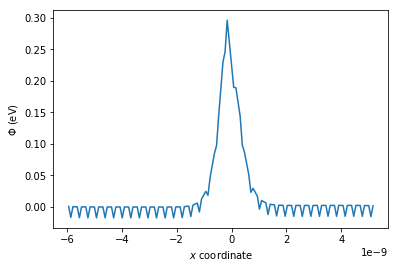

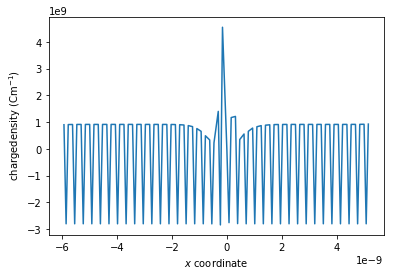

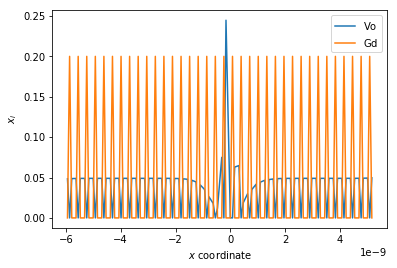

key_data

  core_model   site_model     MS_GC site_charge temperature  \
0        773  [0.05 0.2 ]   0.33517  0.00963335      221569   
1        873  [0.05 0.2 ]   0.32801  0.00966261     61133.1   
2        973  [0.05 0.2 ]  0.321155  0.00968779     22115.6   
3       1000  [0.05 0.2 ]  0.319353  0.00969412     17424.4   
4       1173  [0.05 0.2 ]  0.308277  0.00837419     5550.74   
5       1273  [0.05 0.2 ]  0.302223  0.00837756     3187.59   

       mole_fraction space_charge_potential parallel_resistivity_ratio  \
0  0.524870661512625                0.75023                      False   
1  0.540890287355384               0.746274                      False   
2  0.556897814968529               0.741121                      False   
3  0.561233609511401               0.728981                      False   
4  0.595437038124449               0.699566                      False   
5  0.612871542996122               0.704616                      False   

  perpendicular_resistivity_r

In [8]:
plt.plot(grid.x, c_o.phi)
plt.xlabel( '$x$ $\mathrm{coordinate}$' )
plt.ylabel('$\Phi$ $\mathrm{( eV )}$')
plt.savefig('phi.pdf')
plt.show()

plt.plot(grid.x, c_o.rho)
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel(' $\mathrm{charge density}$ $(\mathrm{C m}^{-1})$')
plt.savefig('rho.pdf')
plt.show()

plt.plot(grid.x, c_o.mf[site_labels[0]], label = '$\mathrm{Vo}$')
plt.plot(grid.x, c_o.mf[site_labels[1]], label = '$\mathrm{Gd}$')
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel('$x_{i}$')
plt.legend()
plt.savefig('mf.pdf')
plt.show()

print('key_data')
print()
print(key_data_appended)
print('all_data')
print()
print(all_data_appended)
print()
print('perpendicular grain boundary resistivity = ', c_o.perpendicular_resistivity_ratio)
print('parallel grain boundary resistivity = ', c_o.parallel_resistivity_ratio)
print('space charge potential = ', max(c_o.phi))
print('Mott-Schottky approximated space charge potential = ', c_o.ms_phi)